In [1]:
import selectivesearch
from torch_snippets import *
from skimage.segmentation import  felzenszwalb  ## selective search implementation only
from torchvision.ops import nms
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:

from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset

# Region Proposals:

Technique that helps in identifying islands of regions where teh pixels are simmilar to one another.



# Selective Search

Using Hierarchial Clustering of sorts to identify simmilar looking pixels based on color, texture, size, shape etc

In [4]:
img_path = "6\\dogs_cats_images\\14.jpg"

In [5]:
img = read(img_path,1)

In [6]:
segments_fz = felzenszwalb(img, scale=200) # scale refers to how mamy segment to idenify

In [7]:
subplots?

Signature: subplots(ims, nc=5, figsize=(5, 5), silent=True, **kwargs)
Docstring: <no docstring>
File:      c:\users\rachi\anaconda3\lib\site-packages\torch_snippets\loader.py
Type:      function


In [8]:
segments_fz

array([[  0,   0,   0, ...,   3,   3,   3],
       [  0,   0,   0, ...,   3,   3,   3],
       [  0,   0,   0, ...,   3,   3,   3],
       ...,
       [ 99,  99,  99, ..., 313, 313, 313],
       [ 99,  99,  99, ..., 313, 313, 313],
       [ 99,  99,  99, ..., 313, 313, 313]], dtype=int64)

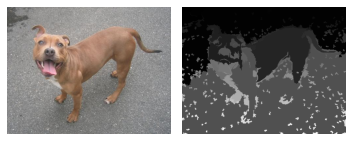

In [9]:
subplots([img, segments_fz])

#### Here we can see that pixels belonging to simmilar group have simmilar pixels

In [10]:
img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)

In [11]:
np.prod(img.shape[:2])

193500

In [12]:
def extract_candidates(img, scale = 200, min_size = 100):
    """
    Performs selective search on top of the given image to generate region proposals
    """
    
    candidates = []   ## final region proposals
    img_lbl, regions = selectivesearch.selective_search(img, scale=scale, min_size=min_size)
    
    img_area = np.prod(img.shape[:2])
    
    
    ### remove very small or very large regions
    
    for region in regions:
        if region['rect'] in candidates:
            continue
        
        elif region['size']  < (0.05 * img_area):
            continue
        
        elif region['size'] > (1*img_area):
            continue
        
        else:
            # x,y,w,h = region['rect']
            candidates.append(list(region['rect']))
    
    return candidates
    
    
    

In [13]:
candidates = extract_candidates(img)

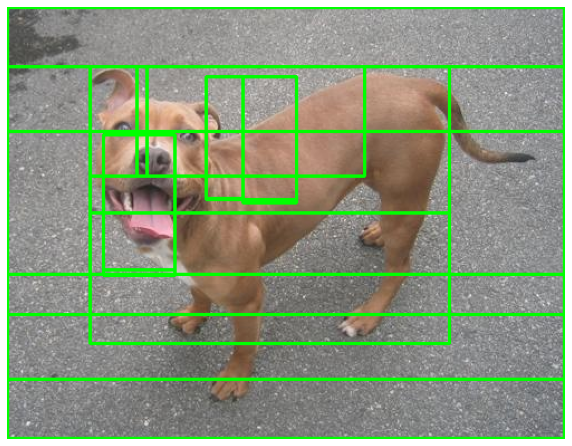

In [14]:
show(img, bbs=candidates)

# Intersection over Union

In [15]:
def get_iou(boxA, boxB, epsilon = 1e-5):
    """
    Calculates intersection over union b.w. 2 bounding boxes
    """
    
    ### coordinates of intersection box
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    
    ### area of intersection
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    
    
    
    ### areas of individual bounding boxes
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou
    
    

# Non Max Suppression

Get the bbox having highest probabilty and remove the boxes having IOU greater than certain threshold.

Can be performed by nms function in torchvision.ops

In [16]:
from torchvision.ops import nms

# Implementing RCNN

In [7]:
base_url = "6\\bus-trucks"

In [8]:
image_root = os.path.join(base_url,'images','images')

In [13]:
df_raw = pd.read_csv(os.path.join(base_url,'df.csv'))

In [14]:
df_raw.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


##### Xmax, Xmin, Ymax, Ymin correspond to Ground Truth

In [21]:
len(df_raw['ImageID'].unique())

15225

In [22]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=image_root) -> None:
        super().__init__()
        self.root = image_folder
        self.df = df
        self.unique_names = df_raw['ImageID'].unique()  ### multiple rows correspond to same image, so getting unique images
        
    def __len__(self):
        return len(self.unique_names)
    
    def __getitem__(self, index):
        image_id = self.unique_names[index]
        image_path = os.path.join(self.root, image_id+".jpg")
        image = read(image_path,1)
        
        h,w,_ = image.shape
        
        df = self.df.copy()
        df = df[df['ImageID']==image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values

        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16)
        
        classes = df['LabelName'].values.tolist()
        
        
        return image, boxes, classes, image_path
    
          

In [23]:
ds = OpenImages(df = df_raw)

In [24]:
image, boxes, classes, image_path = ds[1890]

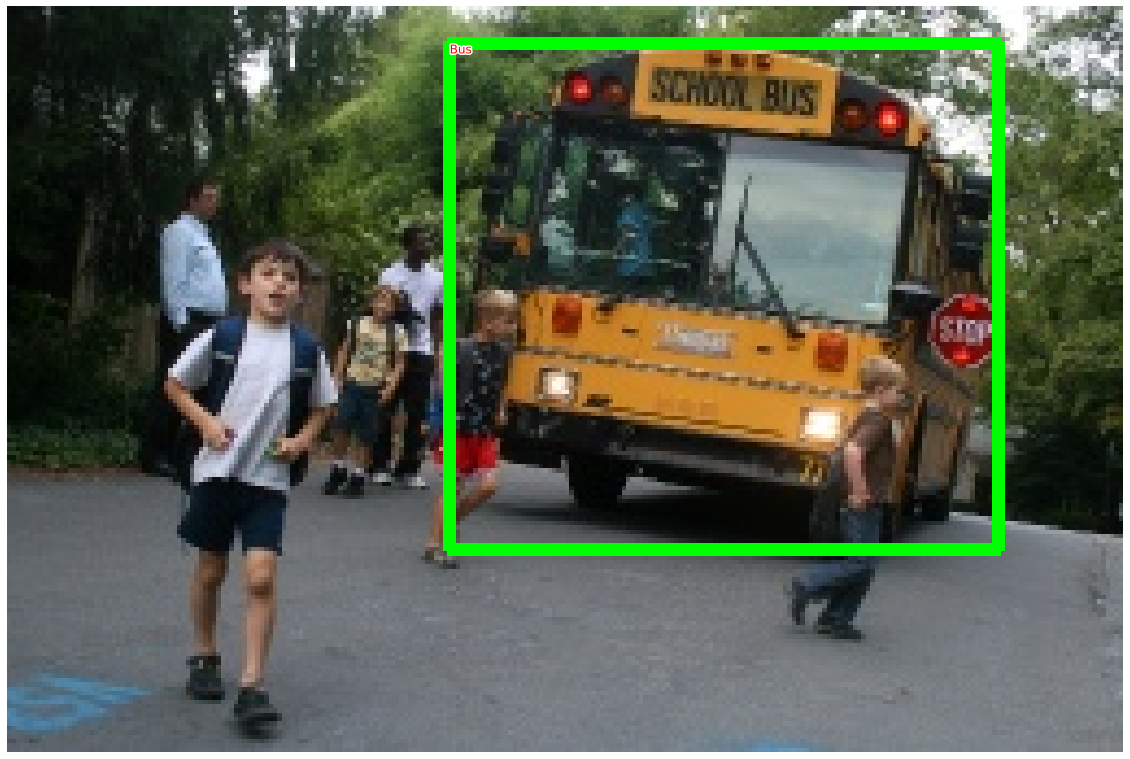

In [25]:
show(image, bbs=boxes, texts=classes, sz=20)

In [26]:
candidates = extract_candidates(image)

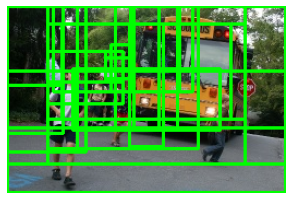

In [27]:
show(image, bbs=candidates)

In [28]:
def extract_candidates(img, scale = 200, min_size = 100):
    """
    Performs selective search on top of the given image to generate region proposals
    """
    
    candidates = []   ## final region proposals
    img_lbl, regions = selectivesearch.selective_search(img, scale=scale, min_size=min_size)
    
    img_area = np.prod(img.shape[:2])
    
    
    ### remove very small or very large regions
    
    for region in regions:
        if region['rect'] in candidates:
            continue
        
        elif region['size']  < (0.05 * img_area):
            continue
        
        elif region['size'] > (1*img_area):
            continue
        
        else:
            # x,y,w,h = region['rect']
            candidates.append(list(region['rect']))
    
    return candidates
    
    
    
def get_iou(boxA, boxB, epsilon = 1e-5):
    """
    Calculates intersection over union b.w. 2 bounding boxes
    """
    
    ### coordinates of intersection box
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    
    ### area of intersection
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    
    
    
    ### areas of individual bounding boxes
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou
    
    


In [29]:
# Fetching region proposals and ground truth offsets

In [30]:
image, boxes, classes, image_path = ds[1]

In [31]:
boxes

array([[ 70,  24, 178,  74],
       [179,  34, 255,  69]], dtype=uint16)

In [32]:
candidates = extract_candidates(image)

In [33]:
candidates[5]

[76, 0, 138, 27]

In [34]:
# convert candidates from x,y,w,h to x,y, x+w, y+h
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

In [35]:
ious = np.array([[get_iou(candidate, _bb_) for candidate in candidates] for _bb_ in boxes]).T

In [36]:
ious.shape

(33, 2)

In [37]:
boxes

array([[ 70,  24, 178,  74],
       [179,  34, 255,  69]], dtype=uint16)

In [38]:
candidates

array([[  0,   0, 118,  32],
       [ 76,   0, 214,  25],
       [109,  73, 255, 169],
       [  0,  78,  82, 169],
       [107,  73, 255, 169],
       [ 76,   0, 214,  27],
       [  0,  23, 117,  98],
       [  0,  78, 102, 169],
       [123,  22, 255,  69],
       [  0,  78, 126, 169],
       [  0,  36, 150, 169],
       [  0,  23, 117,  98],
       [  0,  23, 117,  98],
       [  0,  23, 117,  98],
       [  0,  23, 125, 146],
       [118,  22, 255,  70],
       [  0,   0, 182,  67],
       [  0,   0, 253,  67],
       [  0,  23, 125, 146],
       [  0,  23, 125, 146],
       [107,  62, 255, 169],
       [107,  62, 255, 169],
       [  0,  23, 150, 169],
       [118,  22, 255,  70],
       [  0,   0, 253,  67],
       [  0,  23, 255, 169],
       [  0,   0, 255,  67],
       [ 76,   0, 214,  29],
       [  0,   0, 255,  70],
       [  0,   0, 255,  70],
       [  0,  23, 255, 169],
       [  0,  23, 255, 169],
       [  0,   0, 255, 169]])

In [39]:
ious

array([[0.04367607, 0.        ],
       [0.01165981, 0.        ],
       [0.00356644, 0.        ],
       [0.        , 0.        ],
       [0.00363413, 0.        ],
       [0.03469388, 0.        ],
       [0.1987315 , 0.        ],
       [0.        , 0.        ],
       [0.27111403, 0.42875564],
       [0.        , 0.        ],
       [0.13626177, 0.        ],
       [0.1987315 , 0.        ],
       [0.1987315 , 0.        ],
       [0.1987315 , 0.        ],
       [0.15256588, 0.        ],
       [0.29947917, 0.40450122],
       [0.35861004, 0.00670959],
       [0.26226916, 0.14223309],
       [0.15256588, 0.        ],
       [0.15256588, 0.        ],
       [0.04179749, 0.02961479],
       [0.04179749, 0.02961479],
       [0.17167382, 0.        ],
       [0.29947917, 0.40450122],
       [0.26226916, 0.14223309],
       [0.14504432, 0.07144776],
       [0.26029931, 0.14550096],
       [0.05735493, 0.        ],
       [0.2717427 , 0.14901961],
       [0.2717427 , 0.14901961],
       [0.

In [40]:
len(ious), len(candidates)

(33, 33)

In [41]:
for jx, candidate in enumerate(candidates):
    cx, cy, cX, cY = candidate
    candidate_ious = ious[jx]
    
    break

In [42]:
candidate_ious

array([0.04367607, 0.        ])

In [43]:
FPATHS , GTBBS, CLSS, DELTAS, ROIS , IOUS = [],[],[],[],[],[]
N = 500  # oNLY DOING this for 500 images

for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if ix==N:
        break
    
    H,W, _ = im.shape
    
    candidates = extract_candidates(im)
    
    ## convert rois from x, y,w , h to x,y, x+w, y+h
    candidates = np.array([(x,y,x+w,x+h) for x, y, w, h in candidates])
    
    
    ious, rois, clss, deltas = [], [], [],[]
    ious = np.array([[get_iou(candidate, __bb__) for candidate in candidates] for __bb__ in bbs ]).T
    

    ## iterate over each candidate to get corresponding delta, roi
    
    for jx, candidate in enumerate(candidates):
        cx,cy, cX,cY = candidate
        candidate_ious = ious[jx]


        best_iou_at = np.argmax(candidate_ious)
        
        best_iou = candidate_ious[best_iou_at]
        
        best_bb = _x, _y  , _X, _Y = bbs[best_iou_at]
        
        if best_iou> 0.3:
            
            clss.append(labels[best_iou_at])
        
        else:
            clss.append('background')
        
        
        delta = np.array([_x - cx, _y - cy, _X - cX, _Y- cY]) / np.array([W,H,W,H])
        
        deltas.append(delta)
        
        rois.append(candidate / np.array([W,H,W,H]))
        
                
        
        ## print(clss, candidate_ious)
        
        
        
        
        
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    
    GTBBS.append(bbs)
    
    

        
        
    
        
        
#FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]
# not doing this
        
    
    
    
    
    

##### Indices to each class

In [44]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
     

In [45]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [46]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [47]:
#### RCNN dataset class

In [48]:

class RCNNDataSet(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.rois = rois 
        self.labels = labels
        self.deltas = deltas 
        self.gtbbs =gtbbs
        
    def __len__(self):
        return len(self.fpaths)
    
    
    def __getitem__(self, index):
        
        fpath = str(self.fpaths[index])
        img = read(fpath, 1)
        
        H,W,_ = img.shape
        
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[index]
        
        
        rois = self.rois[index]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        
        labels = self.labels[index]
        
        deltas = self.deltas[index]
        
        crops = [img[y:Y, x:X] for (x,y,X,Y) in bbs]
        
        for i, crop in enumerate(crops):
            if len(crop) == 0:
                #print(i)
                #print(crops[i+1])
                #print(crops[i+1].shape)
                temp_crop = np.ones(shape=(224,224,3))
                crops[i] = temp_crop
                
                
        
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [],[],[],[],[]
        
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]    

            # crops = []
            # for crop in crops:
            #     if crop == []:
            #         crop = np.array(1).reshape(1,1,1)
            #         crops.append(crop)
            #     else:
            #         crops.append(resize(crop, (224,224)))
            
            crops = [resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_img(crop/255.)[None] for crop in crops]        
            input.extend(crops)
            
            labels.extend([label2target[c] for c in image_labels])
            
            deltas.extend(image_deltas)
            
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas
        
        
        

In [49]:

n_train = 9*len(FPATHS)//10
train_ds = RCNNDataSet(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataSet(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])


train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

# RCNN network architecture

In [50]:
vgg_backbone = models.vgg16(progress=True, pretrained = True)



c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
print(vgg_backbone)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [52]:
vgg_backbone.classifier = nn.Sequential()

## freezing the other weight
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device=device)   ### reflecting that will be used only for evaluation


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [60]:
class RCNN(nn.Module):
    def __init__(self) -> None:
        
        
        
        
        super().__init__()
        vgg_backbone = models.vgg16(progress=True, pretrained = True)
        vgg_backbone.classifier = nn.Sequential()

        ## freezing the other weight
        for param in vgg_backbone.parameters():
            param.requires_grad = False
        vgg_backbone.eval().to(device=device) 

        
        
        
        
        
        feature_dim = 25088
        
        
        
        
        self.backbone = vgg_backbone
        
        self.clss_score = nn.Linear(feature_dim, len(label2target))
        
        self.bbox = nn.Sequential(
            ## adding myself
            #nn.Flatten(),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512,4),
            nn.Tanh()  # output is the delta , so can go from -1 to 1. Hence no Rely
        )
        
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
        
        
    def forward(self, input):
        feat = self.backbone(input)
        clss_score = self.clss_score(feat)
        
        bbox = self.bbox(feat)
        
        return clss_score, bbox
    
    def calc_loss(self, probs, _deltas , labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels!=0)  ### not considering the background classification
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        
        self.lmb = 10.0
        
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss
        
        

In [61]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    
    
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
    

In [62]:

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [63]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

In [64]:
import warnings

In [65]:
warnings.filterwarnings('ignore')

EPOCH: 5.000  val_loss: 1.071  val_loc_loss: 0.156  val_regr_loss: 0.092  val_acc: 0.935  (850.65s - 0.00s remaining)))))

100%|██████████| 106/106 [00:00<00:00, 3530.95it/s]


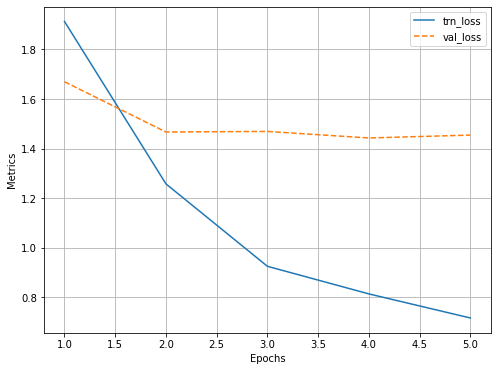

In [66]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        #print('here1')
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        #print('here2')
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        #print('here3')
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [67]:
def test_predictions(filename, show_output=True):
    img = np.array(read(filename,1))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_img(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf
    

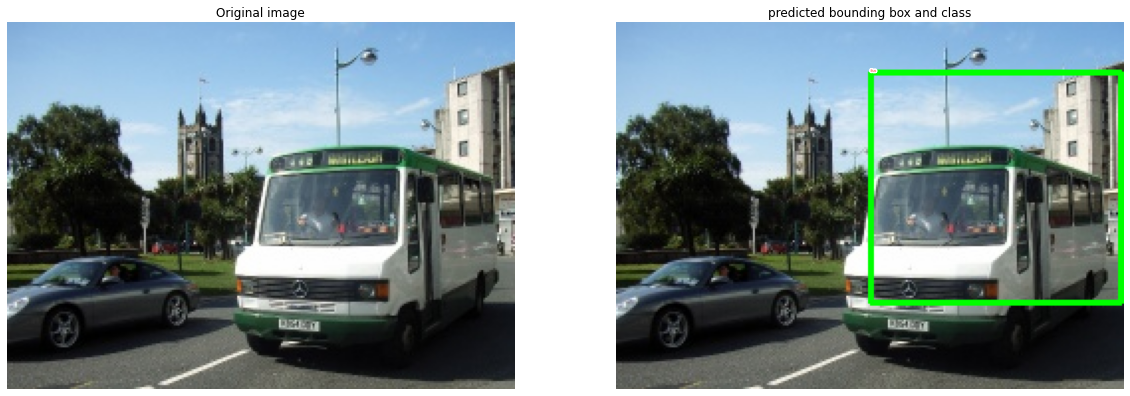

((128, 25, 254, 141), 'Bus', 0.9502934)

In [82]:

index  = np.random.choice(len(test_ds))
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[index]
test_predictions(fpath)

# Fast RCNN

In [15]:
from torchvision.ops import RoIPool

In [16]:
image_root

'6\\bus-trucks\\images\\images'

In [17]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder = image_root) -> None:
        self.root = image_folder
        self.df = df
        self.unique_images = df["ImageID"].unique()
        
        
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_path = os.path.join(self.root,image_id+".jpg")
        image = read(image_path, 1)
        
        h, w , _ = image.shape
        
        df = self.df.copy()
        
        
        df = df[df['ImageID'] == image_id]
        
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        
        classes = df['LabelName'].values.tolist()
        
        
        return image, boxes, classes, image_path
    
    

        
        

In [18]:
ds = OpenImages(df = df_raw)

In [19]:
image, boxes, classes, image_path = ds[90]


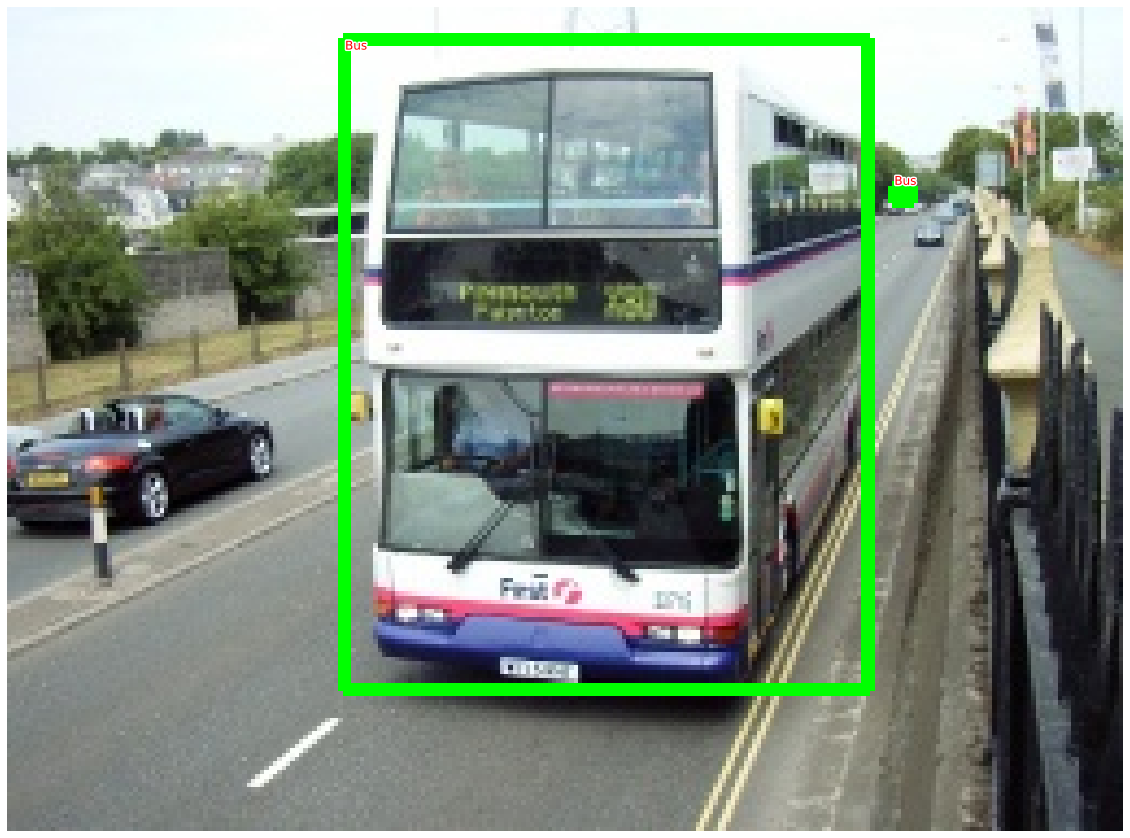

In [20]:
show(image, bbs=boxes, texts=classes, sz=20)

In [21]:
def extract_candidates(img, scale = 200, min_size = 100):
    """
    Performs selective search on top of the given image to generate region proposals
    """
    
    candidates = []   ## final region proposals
    img_lbl, regions = selectivesearch.selective_search(img, scale=scale, min_size=min_size)
    
    img_area = np.prod(img.shape[:2])
    
    
    ### remove very small or very large regions
    
    for region in regions:
        if region['rect'] in candidates:
            continue
        
        elif region['size']  < (0.05 * img_area):
            continue
        
        elif region['size'] > (1*img_area):
            continue
        
        else:
            # x,y,w,h = region['rect']
            candidates.append(list(region['rect']))
    
    return candidates
    
    
    
def get_iou(boxA, boxB, epsilon = 1e-5):
    """
    Calculates intersection over union b.w. 2 bounding boxes
    """
    
    ### coordinates of intersection box
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    
    ### area of intersection
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    
    
    
    ### areas of individual bounding boxes
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou
    
    


In [22]:
FPATHS , GTBBS, CLSS, DELTAS, ROIS , IOUS = [],[],[],[],[],[]
N = 500  # oNLY DOING this for 500 images

for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if ix==N:
        break
    
    H,W, _ = im.shape
    
    candidates = extract_candidates(im)
    
    ## convert rois from x, y,w , h to x,y, x+w, y+h
    candidates = np.array([(x,y,x+w,x+h) for x, y, w, h in candidates])
    
    
    ious, rois, clss, deltas = [], [], [],[]
    ious = np.array([[get_iou(candidate, __bb__) for candidate in candidates] for __bb__ in bbs ]).T
    

    ## iterate over each candidate to get corresponding delta, roi
    
    for jx, candidate in enumerate(candidates):
        cx,cy, cX,cY = candidate
        candidate_ious = ious[jx]


        best_iou_at = np.argmax(candidate_ious)
        
        best_iou = candidate_ious[best_iou_at]
        
        best_bb = _x, _y  , _X, _Y = bbs[best_iou_at]
        
        if best_iou> 0.3:
            
            clss.append(labels[best_iou_at])
        
        else:
            clss.append('background')
        
        
        delta = np.array([_x - cx, _y - cy, _X - cX, _Y- cY]) / np.array([W,H,W,H])
        
        deltas.append(delta)
        
        rois.append(candidate / np.array([W,H,W,H]))
        
                
        
        ## print(clss, candidate_ious)
        
        
        
        
        
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    
    GTBBS.append(bbs)
    
    

        
        
    
        
        
#FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]
# not doing this
        
    
    
    
    
    

In [23]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
     

In [24]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [25]:
def preprocess_img(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

def decode(_y):
    _, preds = _y.max(-1)
    return preds

In [26]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs) -> None:
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, index):
        fpath = str(self.fpaths[index])
        image = read(fpath,1)
        
        gtbbs = self.gtbbs[index]
        rois = self.rois[index]
        labels = self.labels[index]
        
        deltas = self.deltas[index]
        
        assert len(rois) == len(labels) ==len(deltas), f'{len(rois)}, {len(labels), len(deltas)}'
        
        ## no need tp perform crops
        
        return image, rois, labels, deltas, gtbbs, fpath
    
    def collate_fn(self, batch):
        
        input, rois, rixs, labels, deltas= [],[],[],[],[]
         
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix] 
            
            image  = cv2.resize(image, (224,224)) 
            input.append(preprocess_img(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix] * len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
            
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        
        deltas = torch.Tensor(deltas).float().to(device)
        
        return input, rois, rixs, labels, deltas
        
            
            
             

In [27]:

n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])


train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

# FastRCNN model

In [28]:
rawnet = models.vgg16_bn(progress=True, pretrained = True)


c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rachi\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
print(rawnet)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU(inplace=True)
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (19): ReLU(inplace=True)
    (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (26): ReLU(inplace=True)
    (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (32): ReLU(inplace=True)
    (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (36): ReLU(inplace=True)
    (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (39): ReLU(inplace=True)
    (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (42): ReLU(inplace=True)
    (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [30]:
rawnet.features.parameters()

<generator object Module.parameters at 0x00000290BC1E7660>

In [31]:
rawnet.parameters()

<generator object Module.parameters at 0x00000290BC1E74A0>

In [32]:
for param in rawnet.features.parameters():
    param.requires_grad = False

In [33]:
print(*list(rawnet.features.children()))

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) BatchNorm2d(64, eps=1e-05, momentum=0.1, 
affine=True, track_running_stats=True) ReLU(inplace=True) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 
padding=(1, 1)) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(64, 128, kernel_size=(3, 3), 
stride=(1, 1), padding=(1, 1)) BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
ReLU(inplace=True) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) BatchNorm2d(128, eps=1e-05, 
momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) MaxPool2d(kernel_size=2, stride=2, 
padding=0, dilation=1, ceil_mode=False) Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) Conv2d(256, 
256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 
track_running_stats=True) ReLU(inplace=True) Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) 
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(256, 512, kernel_size=(3, 3), 
stride=(1, 1), padding=(1, 1)) BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
ReLU(inplace=True) Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) BatchNorm2d(512, eps=1e-05, 
momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) Conv2d(512, 512, kernel_size=(3, 3), 
stride=(1, 1), padding=(1, 1)) BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
ReLU(inplace=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) Conv2d(512, 512, 
kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 
track_running_stats=True) ReLU(inplace=True) Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) Conv2d(512, 
512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, 
track_running_stats=True) ReLU(inplace=True) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 
ceil_mode=False)

In [34]:
seq = nn.Sequential(*list(rawnet.features.children()))[:-1]

In [35]:
print(seq)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU(inplace=True)
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (19): ReLU(inplace=True)
  (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (22): ReLU(inplace=True)
  (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (24): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (26): ReLU(inplace=True)
  (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (29): ReLU(inplace=True)
  (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (32): ReLU(inplace=True)
  (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (36): ReLU(inplace=True)
  (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (39): ReLU(inplace=True)
  (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (42): ReLU(inplace=True)
)

In [36]:
from torchsummary import summary

In [37]:
print(summary(seq, torch.zeros((1,3,224,224))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 224, 224]        (1,792)
├─BatchNorm2d: 1-2                       [-1, 64, 224, 224]        (128)
├─ReLU: 1-3                              [-1, 64, 224, 224]        --
├─Conv2d: 1-4                            [-1, 64, 224, 224]        (36,928)
├─BatchNorm2d: 1-5                       [-1, 64, 224, 224]        (128)
├─ReLU: 1-6                              [-1, 64, 224, 224]        --
├─MaxPool2d: 1-7                         [-1, 64, 112, 112]        --
├─Conv2d: 1-8                            [-1, 128, 112, 112]       (73,856)
├─BatchNorm2d: 1-9                       [-1, 128, 112, 112]       (256)
├─ReLU: 1-10                             [-1, 128, 112, 112]       --
├─Conv2d: 1-11                           [-1, 128, 112, 112]       (147,584)
├─BatchNorm2d: 1-12                      [-1, 128, 112, 112]       (256)
├─ReLU: 1-13                             [-1, 128

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Conv2d: 1-1                            [-1, 64, 224, 224]        (1,792)
├─BatchNorm2d: 1-2                       [-1, 64, 224, 224]        (128)
├─ReLU: 1-3                              [-1, 64, 224, 224]        --
├─Conv2d: 1-4                            [-1, 64, 224, 224]        (36,928)
├─BatchNorm2d: 1-5                       [-1, 64, 224, 224]        (128)
├─ReLU: 1-6                              [-1, 64, 224, 224]        --
├─MaxPool2d: 1-7                         [-1, 64, 112, 112]        --
├─Conv2d: 1-8                            [-1, 128, 112, 112]       (73,856)
├─BatchNorm2d: 1-9                       [-1, 128, 112, 112]       (256)
├─ReLU: 1-10                             [-1, 128, 112, 112]       --
├─Conv2d: 1-11                           [-1, 128, 112, 112]       (147,584)
├─BatchNorm2d: 1-12                      [-1, 128, 112, 112]       (256)
├─ReLU: 1-13                             [-1, 128, 112, 112]       --
├─MaxPool2d: 1-14                        [-1, 128, 56, 56]         --
├─Conv2d: 1-15                           [-1, 256, 56, 56]         (295,168)
├─BatchNorm2d: 1-16                      [-1, 256, 56, 56]         (512)
├─ReLU: 1-17                             [-1, 256, 56, 56]         --
├─Conv2d: 1-18                           [-1, 256, 56, 56]         (590,080)
├─BatchNorm2d: 1-19                      [-1, 256, 56, 56]         (512)
├─ReLU: 1-20                             [-1, 256, 56, 56]         --
├─Conv2d: 1-21                           [-1, 256, 56, 56]         (590,080)
├─BatchNorm2d: 1-22                      [-1, 256, 56, 56]         (512)
├─ReLU: 1-23                             [-1, 256, 56, 56]         --
├─MaxPool2d: 1-24                        [-1, 256, 28, 28]         --
├─Conv2d: 1-25                           [-1, 512, 28, 28]         (1,180,160)
├─BatchNorm2d: 1-26                      [-1, 512, 28, 28]         (1,024)
├─ReLU: 1-27                             [-1, 512, 28, 28]         --
├─Conv2d: 1-28                           [-1, 512, 28, 28]         (2,359,808)
├─BatchNorm2d: 1-29                      [-1, 512, 28, 28]         (1,024)
├─ReLU: 1-30                             [-1, 512, 28, 28]         --
├─Conv2d: 1-31                           [-1, 512, 28, 28]         (2,359,808)
├─BatchNorm2d: 1-32                      [-1, 512, 28, 28]         (1,024)
├─ReLU: 1-33                             [-1, 512, 28, 28]         --
├─MaxPool2d: 1-34                        [-1, 512, 14, 14]         --
├─Conv2d: 1-35                           [-1, 512, 14, 14]         (2,359,808)
├─BatchNorm2d: 1-36                      [-1, 512, 14, 14]         (1,024)
├─ReLU: 1-37                             [-1, 512, 14, 14]         --
├─Conv2d: 1-38                           [-1, 512, 14, 14]         (2,359,808)
├─BatchNorm2d: 1-39                      [-1, 512, 14, 14]         (1,024)
├─ReLU: 1-40                             [-1, 512, 14, 14]         --
├─Conv2d: 1-41                           [-1, 512, 14, 14]         (2,359,808)
├─BatchNorm2d: 1-42                      [-1, 512, 14, 14]         (1,024)
├─ReLU: 1-43                             [-1, 512, 14, 14]         --
==========================================================================================
Total params: 14,723,136
Trainable params: 0
Non-trainable params: 14,723,136
Total mult-adds (G): 15.35
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 206.72
Params size (MB): 56.16
Estimated Total Size (MB): 263.46
==========================================================================================

In [38]:
RoIPool?

Init signature: RoIPool(output_size: None, spatial_scale: float)
Docstring:      See :func:`roi_pool`.
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           c:\users\rachi\anaconda3\lib\site-packages\torchvision\ops\roi_pool.py
Type:           type
Subclasses:     


In [39]:
from torchvision.ops import roi_pool

In [40]:
roi_pool?

Signature:
roi_pool(
    input: torch.Tensor,
    boxes: Union[torch.Tensor, List[torch.Tensor]],
    output_size: None,
    spatial_scale: float = 1.0,
) -> torch.Tensor
Docstring:
Performs Region of Interest (RoI) Pool operator described in Fast R-CNN

Args:
    input (Tensor[N, C, H, W]): The input tensor, i.e. a batch with ``N`` elements. Each element
        contains ``C`` feature maps of dimensions ``H x W``.
    boxes (Tensor[K, 5] or List[Tensor[L, 4]]): the box coordinates in (x1, y1, x2, y2)
        format where the regions will be taken from.
        The coordinate must satisfy ``0 <= x1 < x2`` and ``0 <= y1 < y2``.
        If a single Tensor is passed, then the first column should
        contain the index of the corresponding element in the batch, i.e. a number in ``[0, N - 1]``.
        If a list of Tensors is passed, then each Tensor will correspond to the boxes for an element i
        in the batch.
    output_size (int or Tuple[int, int]): the size of the output after 

In [41]:
inputs, rois, rixs, labels, deltas = next(iter(train_loader))

<ipython-input-26-88af89be118b>:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  rois = torch.Tensor(rois).float().to(device)


In [42]:
print(rixs)

tensor[81] x∈[0., 1.000] μ=0.407 σ=0.494 cuda:0

In [43]:
rixs.view(-1,1)

tensor[81, 1] x∈[0., 1.000] μ=0.407 σ=0.494 cuda:0

In [44]:
rixs.unsqueeze(-1)

tensor[81, 1] x∈[0., 1.000] μ=0.407 σ=0.494 cuda:0

In [45]:
rois.shape

torch.Size([81, 4])

In [46]:
### Will concatenate rixs and rois so that they can be passed through ROI Pool layer

In [47]:
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet = models.vgg16_bn(pretrained = True, progress=True)
        for param in rawnet.features.parameters():
            param.requires_grad = False  ### different than the book
            
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        
        self.roi_pool = RoIPool(output_size=7, spatial_scale=14/224)   # 14 is output size, 224 is input size
        
        features_dim = 512*7*7
        
        self.cls_score = nn.Linear(features_dim, len(label2target))
        
        self.bbox = nn.Sequential(
            nn.Linear(features_dim,512),
            nn.ReLU(),
            nn.Linear(512,4),
            nn.Tanh()
        )
        
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
        
    def forward(self, input, rois, ridxs):
        res = input
        res = self.seq(res)
        
        rois = torch.cat([ridxs.unsqueeze(-1), rois*224], dim = -1)  ## ridx.unsqueeze(-1) same as ridx.view(-1,1)
        res = self.roi_pool(res, rois)
        feat  = res.view(len(res),-1)
        
        cls_score = self.cls_score(feat)
        
        bbox = self.bbox(feat)
        return cls_score, bbox
    
    def calc_loss(self, probs, _deltas, deltas, labels):
        #print("prob : predicted",probs)  # predicted
        
        #print("labels: actual ", labels) ## actual
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        
        self.lmb = 10.0
        
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss
        
        
            
        
        
        
        
            
        
        
        
        

In [48]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    
    _clss, _deltas = model(input, rois, rixs)
    # print("class", _clss)
    # print("deltas",_deltas)
    # print("actual class", clss)
    # print("actual delta", deltas)
    
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, deltas, clss)
    
    
    
    accs = clss == decode(_clss)
    
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
    

In [51]:
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, deltas, clss)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

EPOCH: 1.000  val_loss: 2.042  val_regr_loss: 0.119  trn_loss: 1.953  val_loc_loss: 0.852  trn_loc_loss: 0.789  val_acc: 0.747  trn_acc: 0.709  trn_regr_loss: 0.116  (8.18s - 32.73s remaining)
EPOCH: 2.000  val_loss: 2.008  val_regr_loss: 0.117  trn_loss: 1.423  val_loc_loss: 0.836  trn_loc_loss: 0.555  val_acc: 0.745  trn_acc: 0.804  trn_regr_loss: 0.087  (16.15s - 24.23s remaining)
EPOCH: 3.000  val_loss: 1.999  val_regr_loss: 0.117  trn_loss: 1.155  val_loc_loss: 0.825  trn_loc_loss: 0.466  val_acc: 0.753  trn_acc: 0.842  trn_regr_loss: 0.069  (24.17s - 16.11s remaining)
EPOCH: 4.000  val_loss: 1.931  val_regr_loss: 0.111  trn_loss: 1.015  val_loc_loss: 0.822  trn_loc_loss: 0.410  val_acc: 0.758  trn_acc: 0.867  trn_regr_loss: 0.060  (32.17s - 8.04s remaining)
EPOCH: 5.000  val_loss: 1.984  val_regr_loss: 0.116  trn_loss: 0.908  val_loc_loss: 0.825  trn_loc_loss: 0.370  val_acc: 0.756  trn_acc: 0.884  trn_regr_loss: 0.054  (40.20s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 3506.28it/s]


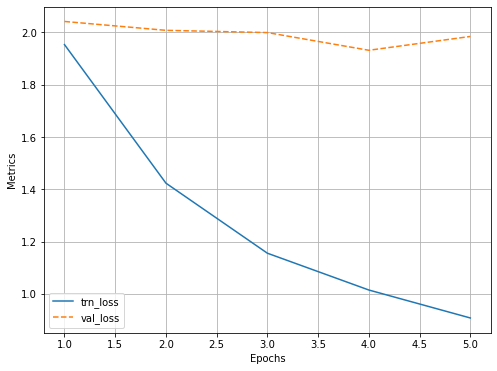

In [53]:

frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_img(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

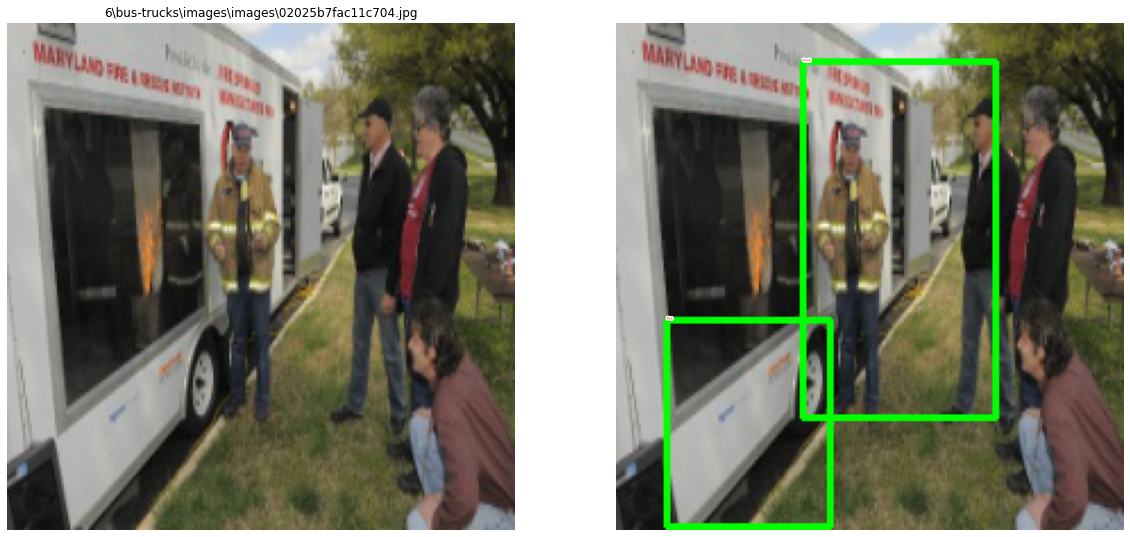

In [59]:

test_predictions(test_ds[4][-1])